## environment


In [ ]:
!pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=bdbb5a736c3b3a2be67716a08261b1cd8866ea57fd3b5f3c7ad8ecfd28a1175b
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import sys
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from google.colab import drive
drive.mount('/content/drive')

TensorFlow 1.x selected.
Mounted at /content/drive


In [ ]:
main_path = "/content/drive/My Drive/Workspace/NN/"
def myprint(string):
  with open(main_path + "logs.txt", "a") as f:
    f.write(string + "\n")

def myprint_tf(item):
  print(item.eval())

In [ ]:
myprint("Hellow world!")
myprint("Hellow world!")

## model

In [ ]:
class PhysicsInformedNN:
    # Initialize the class
  def __init__(self, t0, y0, X_f, layers, lb, ub):
        self.lb = lb
        self.ub = ub

        self.t0 = t0
        self.t_f = X_f
        
        self.y0 = y0
        print(X_f.shape)
        
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.y0_tf = tf.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # self.u_tf = tf.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        # self.v_tf = tf.placeholder(tf.float32, shape=[None, self.y0.shape[1]])

        # tf Graphs
        self.y0_pred = self.net_uv(self.t0_tf)
        self.f_y_pred, self.u_print, self.v_print, self.u_t_print, self.v_t_print, self.f_u_print, self.f_v_print, self.y_print, self.t_print = self.net_f_uv(self.t_f_tf)

        # Loss
        # print(self.x0_tf.shape, self.x0_tf)
        # print(self.y0_tf.shape, self.y0_tf)
        # print(self.x_f_tf.shape, self.x_f_tf)

        self.loss = tf.reduce_mean(tf.square(self.y0_tf - self.y0_pred)) + \
                    tf.reduce_mean(tf.square(self.f_y_pred))
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50, # 5000,
                                                                           'maxfun': 5000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # # tf session
        # self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
        #                                              log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
  def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
  def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
  def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        tf.print("X.shape:", X.shape)
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
  def net_uv(self, t):
        y = self.neural_net(t, self.weights, self.biases)
        return y

  def net_f_uv(self, t):
        y = self.net_uv(t)
        y_t = tf.gradients(y, t)[0]
        u = y[:,0:1]
        v = y[:,1:2]
        u_t = y_t[:, 0:1]
        v_t = y_t[:, 1:2]
        # print("u=")
        # print(u.eval(session=self.sess))
        # print("v=")
        # myprint_tf(v)
        # print("y_t=", y_t, "u_t=", u_t, "v_t=", v_t)
        f_u = u_t - (1-0.3*v)*u
        f_v = v_t - (-3+0.1*u)*v  
        f_y = tf.concat([f_u, f_v], 1);
        # print("f_u=", f_u, "f_y=", f_y)
        return f_y, u, v, u_t, v_t, f_u, f_v, y, t

  def get_u(self, t):
        y = self.net_uv(t)
        y_t = tf.gradients(y, t)[0]
        u = y[:,0:1]
        return u


  def callback(self, loss):
        print('Loss:', loss)
        
  def train(self, nIter):
        tf_dict = {self.t0_tf: self.t0,
                   self.y0_tf: self.y0,
                   self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                u_print = self.sess.run(self.u_print, tf_dict)
                v_print = self.sess.run(self.v_print, tf_dict)

                u_t_print = self.sess.run(self.u_t_print, tf_dict)
                v_t_print = self.sess.run(self.v_t_print, tf_dict)
                f_u_print = self.sess.run(self.f_u_print, tf_dict)
                f_v_print = self.sess.run(self.f_v_print, tf_dict)
                y_print = self.sess.run(self.y_print, tf_dict)
                t_print = self.sess.run(self.t_print, tf_dict)
                print("u=\n", u_print)
                print("v=\n", v_print)
                print("u_t=\n", u_t_print)
                print("v_t=\n", v_t_print)
                print("f_u=\n", f_u_print)
                print("f_v=\n", f_v_print)
                print("y=\n", y_print)
                print("t=\n", t_print)
                
                start_time = time.time()
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
  def predict(self, X_star):
        tf_dict = {self.t0_tf: X_star}  
        y_star = self.sess.run(self.y0_pred, tf_dict) 
        tf_dict = {self.t_f_tf: X_star}
        f_y_star = self.sess.run(self.f_y_pred, tf_dict)    
        return y_star, f_y_star

## main

In [ ]:
if __name__ == "__main__": 
     
    np.random.seed(123)
    tf.set_random_seed(123)
    noise = 0.0        
    
    # lower/upper bounds of time
    lb = np.zeros(2).reshape([1,-1])
    ub = np.repeat(20,2).reshape([1,-1])

    # collocation points
    N_f = 20000

    # neural network layers setup
    # input time = [t0 t0] (2, 1)
    # output Y = [y1, y2]
    layers = [2, 100, 100, 100, 2]

    # data = scipy.io.loadmat('/content/drive/My Drive/PINN/test_PP.mat')
    data = scipy.io.loadmat('/content/drive/My Drive/Workspace/NN/test_PP.mat')
    t = data['TOUT'].flatten()[:,None]
    Exact = data['YOUT']
    
    # (51456, 2) (51456, 1) pair-wise stack 
    # X_star is used for prediction. X_star
    X_star = t.T.flatten().reshape([-1,1])
    y_star = Exact

    for i in range(1):
      X_star = np.append(X_star, t, axis=1)

    # print(X_star.shape)

    ###########################
    
    # initial condition
    t0 = np.zeros(2).reshape([1,-1])
    y0 = Exact[0,0:2].reshape([1,-1])
    print("t0({})={}".format(t0.shape, t0))
    print("y0({})={}".format(y0.shape, y0))
    
    # cooredinates between lb and ub
    X_f = lb + (ub-lb)*lhs(1, N_f) 
    X_f = sorted(X_f, key=lambda xx: xx[0])
    X_f = np.asarray(X_f)
    # print(X_f.shape, X_f)

    # PhysicsInformedNN(initialx, initialy1, X_f (collocation points), layers, lb (x,t), ub)
    model = PhysicsInformedNN(t0, y0, X_f, layers, lb, ub)
             
    start_time = time.time()                
    model.train(500)
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    print(X_star.shape, "X_star")

    y_pred, f_y_pred = model.predict(X_star)
    error_y = np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)
    print('Error y: %e' % (error_y))

t0((1, 2))=[[0. 0.]]
y0((1, 2))=[[10.  5.]]
(20000, 2)
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

It: 0, Loss: 6.148e+01, Time: 0.42
u=
 [[ 0.08243964]
 [ 0.08243643]
 [ 0.08243128]
 ...
 [-0.04077232]
 [-0.0407772 ]
 [-0.04078293]]
v=
 [[ 0.03960941]
 [ 0.03960832]
 [ 0.03960659]
 ...
 [-0.00614203]
 [-0.00614375]
 [-0.00614581]]
u_t=
 [[-0.00476704]
 [-0.00476702]
 [-0.00476698]
 ...
 [-0.00502658]
 [-0.00502661]
 [-0.00502668]]
v_t=
 [[-0.00255895]
 [-0.00255911]
 [-0.00255937]
 ...
 [-0.00286324]
 [-0.00286303]
 [-0.00286278]]
f_u=
 [[-0.08622706]
 [-0.08622391]
 [-0.08621881]
 ...
 [ 0.03582087]
 [ 0.03582574]
 [ 0.03583144]]
f_v=
 [[ 0.11594275]
 [ 0.11593934]
 [ 0.11593391]
 ...
 [-0.02131436]
 [-0.02131935]
 [-0.02132526]

In [ ]:
print(model.y0_pred)

Tensor("Add_23:0", shape=(?, 2), dtype=float32)


## Plotting

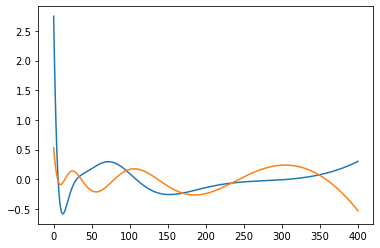

In [ ]:
Y_pred = griddata(X_star, y_pred, X_star, method='nearest')
FY_pred = griddata(X_star, f_y_pred, X_star, method='nearest') 
plt.plot(FY_pred);

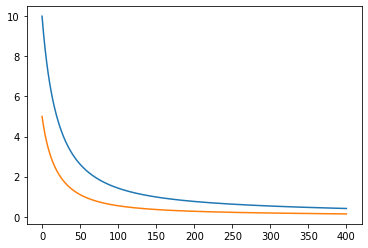

In [ ]:
plt.plot(Y_pred);

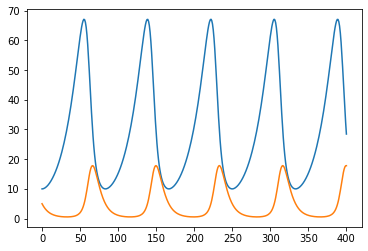

In [ ]:
plt.plot(y_star);

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import sys
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from google.colab import drive
drive.mount('/content/drive')
# data = scipy.io.loadmat('/content/drive/My Drive/PINN/test_PP.mat')
# t = data['TOUT'].flatten()[:,None]
# Exact = data['YOUT']

TensorFlow 1.x selected.
Mounted at /content/drive


In [ ]:
data = scipy.io.loadmat('/content/drive/My Drive/Workspace/NN/test_PP.mat')
t = data['TOUT'].flatten()[:,None]
Exact = data['YOUT']
X_star = t.T.flatten().reshape([-1,1])

In [ ]:
!ls /content/drive/MyDrive/Workspace/NN/

nn_2_layers.ipynb  PINN_PP_ODE.ipynb  test_PP.mat  toy_data.mat


In [ ]:
print(Exact)
# print(X_star)

[[10.          5.        ]
 [10.02420984  4.52437119]
 [10.09402383  4.0949546 ]
 [10.20586771  3.70798562]
 [10.35691707  3.35979405]
 [10.54497437  3.04688421]
 [10.76834075  2.76596143]
 [11.02575346  2.51396091]
 [11.31630175  2.28805267]
 [11.63938254  2.08564204]
 [11.99465455  1.90436501]
 [12.38200035  1.74207459]
 [12.8015057   1.59683286]
 [13.25342777  1.46689188]
 [13.73818502  1.35068401]
 [14.25633679  1.24680395]
 [14.80857204  1.15399655]
 [15.39570216  1.07114414]
 [16.01864718  0.99725172]
 [16.67843254  0.93143865]
 [17.37618171  0.87292626]
 [18.113108    0.8210282 ]
 [18.89051186  0.77514426]
 [19.70977521  0.73475201]
 [20.57235127  0.69939806]
 [21.4797629   0.66869676]
 [22.4335947   0.64232505]
 [23.43548268  0.62001703]
 [24.48710007  0.60156354]
 [25.59015041  0.5868117 ]
 [26.74635157  0.57566368]
 [27.95741673  0.56807778]
 [29.22500844  0.5640764 ]
 [30.55073267  0.56374697]
 [31.93609188  0.56724989]
 [33.38244514  0.57482602]
 [34.89089326  0.58682306]
 

-5.0
-10.004999999999999
[10.0, 9.995, 9.9900324999925, 9.985097401377505, 9.980194606000667, 9.975324016151276, 9.970485534560256, 9.96567906439817, 9.960904509273243, 9.956161773229379, 9.951450760744194, 9.946771376727062, 9.942123526517163, 9.93750711588154, 9.932922051013163, 9.928368238529014, 9.923845585468163, 9.91935399928986, 9.914893387871642, 9.910463659507434, 9.90606472290567, 9.901696487187424, 9.897358861884532, 9.893051756937748, 9.888775082694883, 9.88452874990897, 9.880312669736428, 9.87612675373524, 9.871970913863134, 9.867845062475773, 9.863749112324957, 9.85968297655683, 9.855646568710092, 9.851639802714232, 9.847662592887742, 9.843714853936378, 9.839796500951387, 9.835907449407776, 9.832047615162567, 9.828216914453076, 9.824415263895181, 9.820642580481616, 9.816898781580264, 9.813183784932455, 9.809497508651283, 9.805839871219915, 9.802210791489918, 9.798610188679596, 9.795037982372326, 9.791494092514906, 9.787978439415912, 9.784490943744057, 9.781031526526563, 9

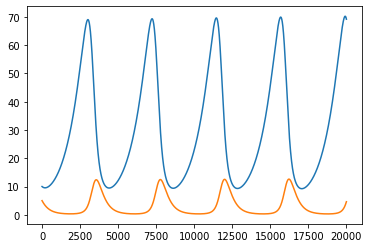

In [ ]:
# Simulation - PP

import numpy as np
import matplotlib.pyplot as plt

T = 20.0
T_unit = 0.001
U_start = 10.0
V_start = 5.0

alpha = 1.0
beta = 3.0
gamma = 0.3
e = 0.333

# dU/dt=alpha*U-gamma*U*V
# dV/dt=-beta*V+e*gamma*U*V

U = [U_start]
V = [V_start]
flag = True
for i in range(1, int(T / T_unit) + 1):
  U_old, V_old = U[-1], V[-1]
  if flag:
    print(((alpha * U_old) - gamma * U_old * V_old))
    print((- beta * V_old + e * gamma* U_old * V_old))
  U_new = U_old + ((alpha * U_old) - gamma * U_old * V_old) * T_unit
  V_new = V_old + (- beta * V_old + e * gamma* U_old * V_old) * T_unit
  U.append(U_new)
  V.append(V_new)
  flag = False
print(U)
print(V)
Y_hat = np.asarray([[u, v] for u, v in zip(U, V)])
plt.plot(Y_hat)

-5.0
-10.004999999999999
[10.0, 10.005, 10.0100245285075, 10.015073538808066, 10.02014698442943, 10.025244819140152, 10.030366996948267, 10.035513472099964, 10.040684199078262, 10.045879132601689, 10.051098227622978, 10.056341439327769, 10.06160872313331, 10.06690003468718, 10.072215329866008, 10.077554564774205, 10.082917695742697, 10.088304679327676, 10.09371547230935, 10.099150031690705, 10.104608314696268, 10.110090278770889, 10.115595881578512, 10.121125081000976, 10.1266778351368, 10.132254102299994, 10.137853841018865, 10.143477010034836, 10.149123568301267, 10.154793474982288, 10.16048668945164, 10.16620317129151, 10.171942880291393, 10.177705776446942, 10.183491819958837, 10.189300971231653, 10.19513319087274, 10.200988439691109, 10.206866678696318, 10.212767869097371, 10.218691972301626, 10.224638949913695, 10.230608763734372, 10.23660137575955, 10.242616748179147, 10.248654843376048, 10.25471562392504, 10.260799052591763, 10.266905092331662, 10.273033706288947, 10.2791848577

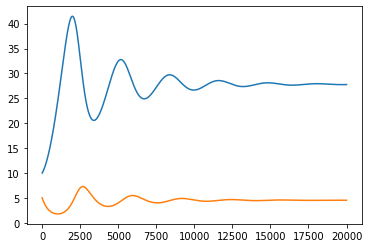

In [ ]:
# Simulation - PP——modified

import numpy as np
import matplotlib.pyplot as plt

T = 20.0
T_unit = 0.001
U_start = 10.0
V_start = 5.0

alpha = 1.0
beta = 3.0
gamma = 0.3
e = 0.333

# dU/dt=alpha*U-gamma*U*V
# dV/dt=-beta*V+e*gamma*U*V

U = [U_start]
V = [V_start]
flag = True
for i in range(1, int(T / T_unit) + 1):
  U_old, V_old = U[-1], V[-1]
  if flag:
    print(((alpha * U_old) - gamma * U_old * V_old))
    print((- beta * V_old + e * gamma* U_old * V_old))
  U_new = U_old + ((alpha * U_old) - gamma * U_old * V_old + 10) * T_unit
  V_new = V_old + (- beta * V_old + e * gamma* U_old * V_old + 1) * T_unit
  U.append(U_new)
  V.append(V_new)
  flag = False
print(U)
print(V)
Y_hat = np.asarray([[u, v] for u, v in zip(U, V)])
plt.plot(Y_hat)

[99.0, 99.0001, 99.000007929806, 98.99972200351719, 98.99924041977759, 98.9985613616687, 98.99768299660201, 98.99660347621128, 98.99532093624482, 98.99383349645758, 98.99213926050314, 98.99023631582563, 98.98812273355165, 98.98579656838207, 98.98325585848383, 98.98049862538173, 98.97752287385028, 98.9743265918055, 98.97090775019684, 98.96726430289915, 98.96339418660475, 98.95929532071558, 98.95496560723558, 98.9504029306631, 98.94560515788366, 98.94057013806275, 98.935295702539, 98.92977966471749, 98.92401981996345, 98.91801394549624, 98.91175980028362, 98.90525512493643, 98.89849764160367, 98.89148505386797, 98.88421504664151, 98.87668528606251, 98.86889341939208, 98.86083707491174, 98.85251386182148, 98.84392137013837, 98.83505717059595, 98.82591881454411, 98.81650383384988, 98.8068097407988, 98.79683402799718, 98.78657416827512, 98.77602761459045, 98.76519179993346, 98.75406413723273, 98.7426420192618, 98.73092281854687, 98.71890388727567, 98.7065825572073, 98.69395613958326, 98.681

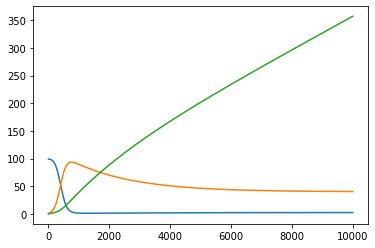

In [ ]:
# Simulation - SIS

import numpy as np
import matplotlib.pyplot as plt

T = 100.0
T_unit = 0.01
S_start = 99.0
I_start = 1.0
R_start = 0.0

beta = 0.01
gamma = 0.05

# dU/dt=alpha*U-gamma*U*V
# dV/dt=-beta*V+e*gamma*U*V

S = [S_start]
I = [I_start]
R = [R_start]
flag = True
for i in range(1, int(T / T_unit) + 1):
  S_old, I_old, R_old = S[-1], I[-1], R[-1]
  S_new = S_old + (- beta * S_old * I_old ) * T_unit
  I_new = I_old + (beta * S_old * I_old - gamma * I_old + 1) * T_unit
  R_new = R_old + (gamma * I_old + 1) * T_unit
  S.append(S_new)
  I.append(I_new)
  R.append(R_new)
  flag = False
print(S)
print(I)
print(R)
Y_hat = np.asarray([[s, i, r] for s, i, r in zip(S, I, R)])
plt.plot(Y_hat)

0.0985
-0.1495005
[0.1, 0.1000985, 0.10019560452386549, 0.100291318203607, 0.10038564567871897, 0.10047859159543399, 0.10057016060599223, 0.1006603573679259, 0.10074918654335857, 0.10083665279831922, 0.10092276080207074, 0.10100751522645302, 0.10109092074523997, 0.10117298203351087, 0.10125370376703546, 0.10133309062167285, 0.10141114727278394, 0.10148787839465731, 0.10156328865994838, 0.10163738273913159, 0.1017101652999656, 0.10178164100697121, 0.1018518145209219, 0.10192069049834687, 0.10198827359104629, 0.10205456844561876, 0.10211957970300077, 0.10218331199801785, 0.10224576995894753, 0.10230695820709375, 0.10236688135637259, 0.10242554401290926, 0.1024829507746461, 0.10253910623096145, 0.10259401496229932, 0.10264768153980959, 0.10270011052499867, 0.10275130646939047, 0.1028012739141975, 0.10285001739000187, 0.10289754141644632, 0.10294385050193479, 0.10298894914334263, 0.10303284182573619, 0.10307553302210172, 0.10311702719308333, 0.10315732878673001, 0.10319644223825152, 0.1032

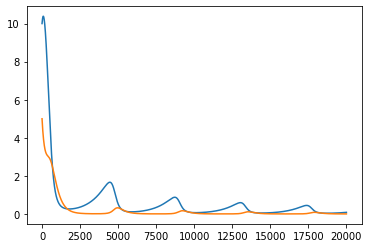

In [ ]:
# Simulation - 2

import numpy as np
import matplotlib.pyplot as plt

T = 20.0
T_unit = 0.001
U_start = 10.0
V_start = 5.0

alpha = 1.0
beta = 3.0
gamma = 0.3
e = 0.333

lb = 0.0
ub = 100.0
i = ub - lb

def encode(num):
  return (num - lb) / (ub - lb)

def decode(num):
  return lb + num * (ub - lb)

# dU/dt=alpha*U-gamma*U*V
# dV/dt=-beta*V+e*gamma*U*V

U = [encode(U_start)]
V = [encode(V_start)]
flag = True
for i in range(1, int(T / T_unit) + 1):
  U_old, V_old = U[-1], V[-1]
  # U_new = U_old + ((alpha * U_old) - gamma * U_old * V_old) * T_unit
  # V_new = V_old + (- beta * V_old + e * gamma* U_old * V_old) * T_unit
  if flag:
    print((alpha - gamma * (i * V_old + lb)) * (i * U_old + lb))
    print((- beta + e * gamma * (U_old * i + lb)) * (V_old * i + lb))
  U_new = U_old + (alpha - gamma * (i * V_old + lb)) * (i * U_old + lb) / i * T_unit
  V_new = V_old + (- beta + e * gamma * (U_old * i + lb)) * (V_old * i + lb) / i * T_unit
  U.append(U_new)
  V.append(V_new)
  flag = False
print(U)
print(V)
Y_hat = np.asarray([[decode(u), decode(v)] for u, v in zip(U, V)])
plt.plot(Y_hat)

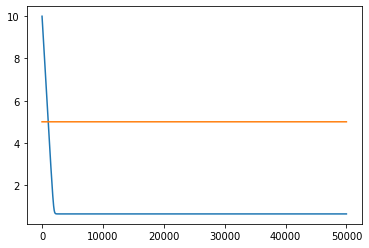

In [ ]:
# Simulation - single

import numpy as np
import matplotlib.pyplot as plt
import math

T = 50.0
T_unit = 0.001
U_start = 10.0
V_start = 5.0

alpha = 1.0
beta = 3.0
gamma = 0.3
e = 0.333

# dU/dt=alpha*U-gamma*U*V
# dV/dt=-beta*V+e*gamma*U*V

U = [U_start]
V = [V_start]
for i in range(1, int(T / T_unit) + 1):
  U_old, V_old = U[-1], V[-1]
  U_new = U_old - (5*math.cos(1/U_old)) * T_unit
  V_new = V_old
  U.append(U_new)
  V.append(V_new)

Y_hat = np.asarray([[u, v] for u, v in zip(U, V)])
plt.plot(Y_hat)

In [ ]:

import tensorflow as tf
import torch
y = tf.constant([9, 4, 1, 1, 4, 9], dtype=float)
t = tf.constant([-3, -2, -1, 1, 2, 3], dtype=float)
print(tf.gradients([y], [t]))

RuntimeError: ignored

In [ ]:
from pyDOE import lhs
import numpy as np

import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from collections import OrderedDict
from sklearn.cluster import KMeans
import random
from torch.backends import cudnn

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)
cudnn.deterministic = True

lb = np.zeros(2).reshape([1,-1])
ub = np.repeat(20,2).reshape([1,-1])
print(lb)
print(ub)
N_f = 20000
X_f = lb + (ub-lb)*lhs(1, N_f)
print(list(X_f))
X_f = sorted(X_f, key=lambda x: x[0])
print(np.asarray(X_f))

[[0. 0.]]
[[20 20]]
[array([14.38572388, 14.38572388]), array([5.47814552, 5.47814552]), array([7.88342598, 7.88342598]), array([19.50773369, 19.50773369]), array([16.59392195, 16.59392195]), array([16.81283461, 16.81283461]), array([19.86637137, 19.86637137]), array([17.23091896, 17.23091896]), array([10.34853141, 10.34853141]), array([4.39080054, 4.39080054]), array([14.42202531, 14.42202531]), array([10.76964467, 10.76964467]), array([7.19261451, 7.19261451]), array([0.15906917, 0.15906917]), array([5.53061172, 5.53061172]), array([13.75869067, 13.75869067]), array([12.03721212, 12.03721212]), array([8.7555702, 8.7555702]), array([13.0761829, 13.0761829]), array([3.09084409, 3.09084409]), array([7.25107569, 7.25107569]), array([12.05253136, 12.05253136]), array([5.25001133, 5.25001133]), array([11.70595927, 11.70595927]), array([15.70884825, 15.70884825]), array([0.94014038, 0.94014038]), array([11.62911261, 11.62911261]), array([10.39346002, 10.39346002]), array([17.70968266, 17.70

In [ ]:
import torch
coordinates = (torch.tensor([-2., -1., 1., 4.]),)
values = torch.tensor([4., 1., 1., 16.], )
print(torch.gradient(values, spacing = coordinates)[0])
print(torch.tensor([-2., -1., 1., 4.]).shape)
print(torch.tensor([4., 1., 1., 16.], ).shape)

tensor([-3., -2.,  2.,  5.])
torch.Size([4])
torch.Size([4])


In [ ]:
lb = 0.0
ub = 100.0
i = ub - lb

def encode(num):
  return (num - lb) / (ub - lb)

def decode(num):
  return lb + num * (ub - lb)

a = torch.Tensor([[10,4], [20,34]])
print(encode(a))

tensor([[0.1000, 0.0400],
        [0.2000, 0.3400]])


In [ ]:
import numpy as np
print(1.0 * np.finfo(float).eps)

2.220446049250313e-16


[50.0, 49.917, 49.834060391484, 49.75118162025891, 49.66836413067431, 49.58560836561378, 49.50291476648632, 49.42028377321785, 49.337715824242736, 49.25521135649548, 49.172770805402386, 49.09039460487336, 49.00808318729377, 48.92583698351639, 48.84365642285339, 48.76154193306846, 48.679493940368914, 48.597512869397995, 48.51559914322715, 48.433753183348415] ... [17.499999999578375, 17.49999999957874, 17.499999999579106, 17.49999999957947, 17.49999999957983, 17.499999999580194, 17.499999999580556, 17.49999999958092, 17.49999999958128, 17.499999999581643, 17.499999999582005, 17.499999999582368, 17.49999999958273, 17.499999999583093, 17.499999999583455, 17.499999999583817, 17.49999999958418, 17.499999999584542, 17.499999999584904, 17.499999999585267]
[49.0, 49.0637, 49.127319918515994, 49.19085934768068, 49.25431788123583, 49.31769511454029, 49.380990644577885, 49.44420406996521, 49.50733499095938, 49.57038300946569, 49.633347729045205, 49.69622875492228, 49.759025693991966, 49.8217381548

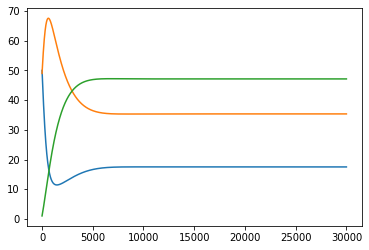

In [ ]:
# Simulation - SIR - modified

import numpy as np
import matplotlib.pyplot as plt

T = 300.0
T_unit = 0.01
S_start = 50.0
I_start = 49.0
R_start = 1.0

beta = 0.4
gamma = 0.04
NN = S_start + I_start + R_start
mu = 0.03
lam = NN * mu




S = [S_start]
I = [I_start]
R = [R_start]

N = S[0] + I[0] + R[0]

flag = True
for i in range(1, int(T / T_unit) + 1):
  S_old, I_old, R_old = S[-1], I[-1], R[-1]
  
  S_new = S_old + (- beta * S_old * I_old / N - mu * S_old + lam) * T_unit
  I_new = I_old + (beta * S_old * I_old / N - gamma * I_old - mu * I_old) * T_unit
  R_new = R_old + (gamma * I_old - mu * R_old) * T_unit
  S.append(S_new)
  I.append(I_new)
  R.append(R_new)
  flag = False

r0 = beta / (gamma + mu)
s_last = (gamma + mu) / beta
i_last = mu / beta * (r0 - 1)
r_last = gamma / beta * (r0 - 1)

print(S[:20], "...", S[-20:])
print(I[:20], "...", I[-20:])
print(R[:20], "...", R[-20:])

print("s_last:", s_last)
print("i_last:", i_last)
print("r_last:", r_last)
Y_hat = np.asarray([[s, i, r] for s, i, r in zip(S, I, R)])
plt.plot(Y_hat)

X: [6.0, 6.0, 6.0000072, 6.0000215923199995, 6.0000431692944325, 6.000071923272137, 6.000107846616333, 6.000150931704596, 6.000201170928827, 6.0002585566952344] ... ... [3.455160457460824, 3.4548305120754446, 3.4545027264560932, 3.4541770996907557, 3.4538536308686143, 3.4535323190800504, 3.4532131634166454, 3.4528961629711814, 3.452581316837643, 3.4522686241112184]
Y: [6.0, 6.0072, 6.01439952, 6.021598566752573, 6.028797146998759, 6.035995267468057, 6.043192934878416, 6.050390155936225, 6.057586937336305, 6.064783285761901] ... ... [3.125215072081442, 3.1270448927241206, 3.1288759611183403, 3.130708277549357, 3.1325418423048963, 3.1343766556751516, 3.1362127179527794, 3.138050029432897, 3.1398885904130767, 3.1417284011933435]
Z: [15.0, 14.9996, 14.999204426666665, 14.998813282861923, 14.998426571461906, 14.99804429535694, 14.997666457451514, 14.997293060664244, 14.996924107927866, 14.996559602189192] ... ... [21.799587092227373, 21.794853680956592, 21.790122060985805, 21.78539223282338

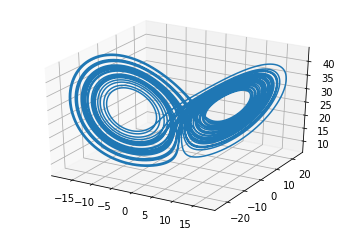

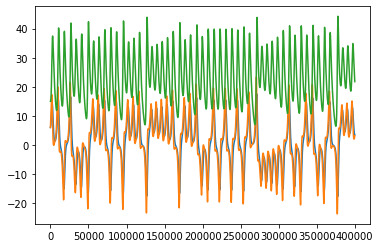

<Figure size 432x288 with 0 Axes>

In [ ]:
# Simulation - Lorenz

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

T = 40.0
T_unit = 0.0001
X_start = 6.0
Y_start = 6.0
Z_start = 15.0

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0



X = [X_start]
Y = [Y_start]
Z = [Z_start]

for i in range(1, int(T / T_unit) + 1):
  X_old, Y_old, Z_old = X[-1], Y[-1], Z[-1]
  
  X_new = X_old + (sigma * (Y_old - X_old)) * T_unit
  Y_new = Y_old + (X_old * (rho - Z_old) - Y_old) * T_unit
  Z_new = Z_old + (X_old * Y_old - beta * Z_old) * T_unit
  X.append(X_new)
  Y.append(Y_new)
  Z.append(Z_new)


print_array_length = 10
print("X:", X[:print_array_length], "... ...", X[-print_array_length:])
print("Y:", Y[:print_array_length], "... ...", Y[-print_array_length:])
print("Z:", Z[:print_array_length], "... ...", Z[-print_array_length:])

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(X, Y, Z)
plt.draw()
plt.show()

plt.plot(np.asarray([[x, y, z] for x, y, z in zip(X, Y, Z)]))
plt.show()
plt.clf()

X: [-4.053, -3.907209809, -3.7635305003878594, -3.622540241501086, -3.4847111826244657, -3.3504184656872606, -3.219949838594201, -3.0935154513804877, -2.9712575011426345, -2.853259476787393] ... ... [-0.30760860851760125, -0.3058579996383484, -0.3040770660828034, -0.3022659903785665, -0.3004249580380313, -0.2985541575394127, -0.29665378030748146, -0.29472402069400744, -0.29276507595791357, -0.29077714624514245]
Y: [-4.468, -4.397066804, -4.323929531474211, -4.249258511851358, -4.173653735552146, -4.097645908643241, -4.02169892478384, -3.946213386421383, -3.8715308499785976, -3.7979385178298593] ... ... [-0.17123680602272184, -0.174291604551151, -0.17732852046540284, -0.18034725285328576, -0.18334750266421307, -0.1863289727387982, -0.18929136783825662, -0.1922343946736117, -0.19515776193470163, -0.19806118031898437]
Z: [25.947, 26.519141649999998, 26.973208816019227, 27.31757479624349, 27.560645841523115, 27.71074342597678, 27.776006549069884, 27.764313181849904, 27.683219419712465, 27.

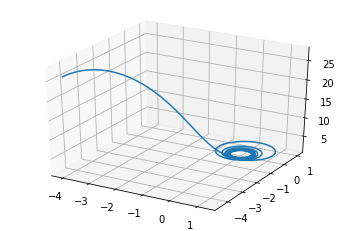

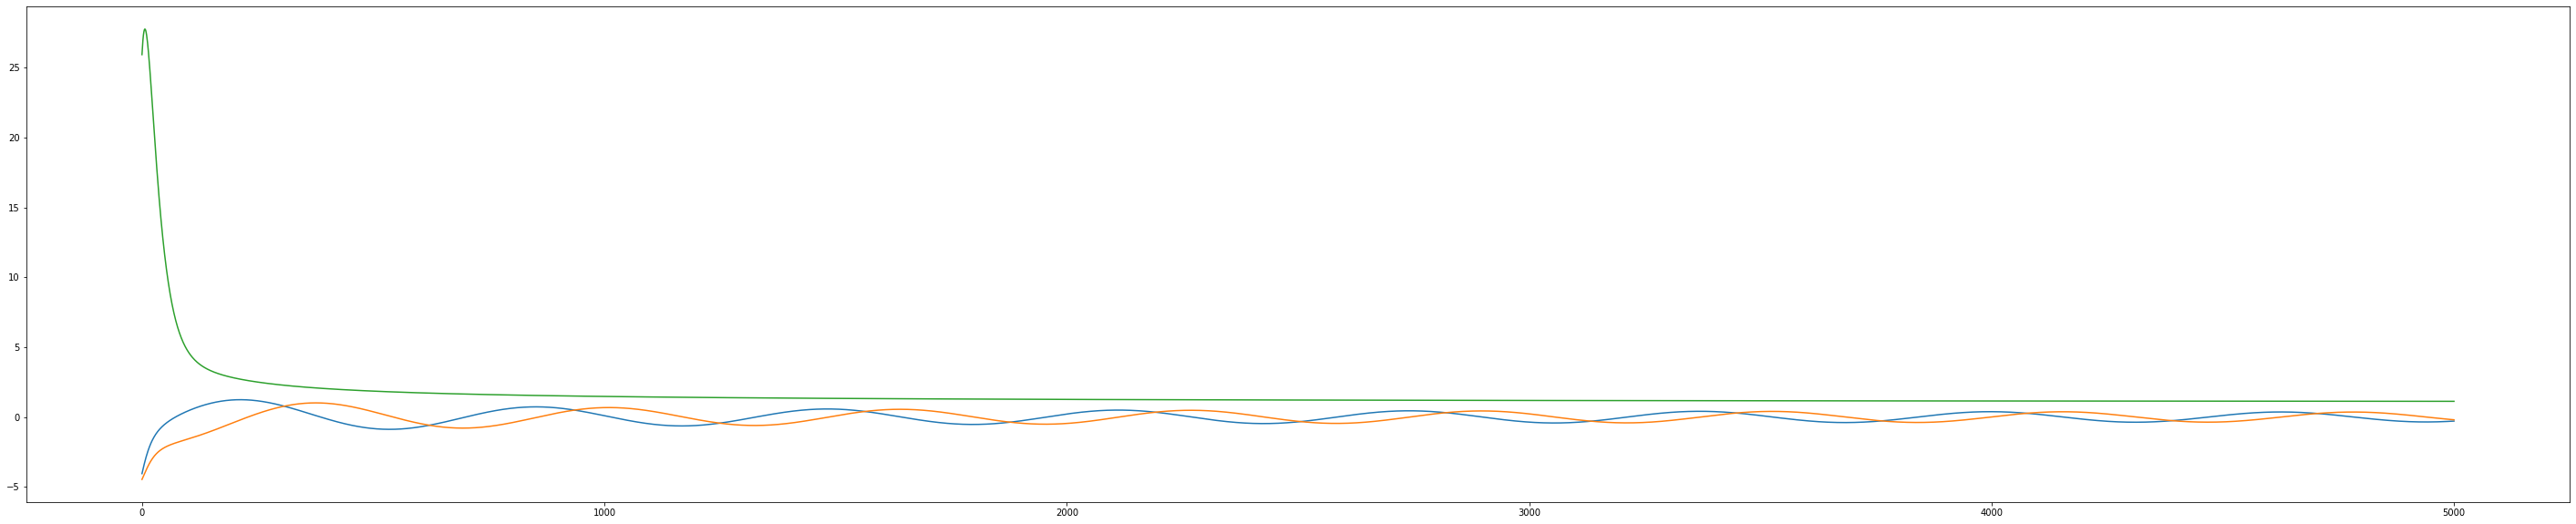

<Figure size 432x288 with 0 Axes>

In [2]:
# Simulation - ULEND

import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D

T = 50.0
T_unit = 0.01


mu = 0.1
omega = 1.0
A = -0.1
lam = 5.0


X_start = -4.053#1.0
Y_start = -4.468#-1.0
Z_start = 25.947#2.0
# -4.053,-4.468,25.947)

# X_start = -math.sqrt(-(mu + omega) / (2 * A)) # 1.0
# Y_start = math.sqrt(-(mu + omega) / (2 * A)) # -1.0
# Z_start = -(mu+omega)/A # 2.0

# print((mu * X_start - omega * Y_start + A * X_start * Z_start))
# print((omega * X_start + mu * Y_start + A * Y_start * Z_start))
# print((- lam * (Z_start - X_start ** 2 - Y_start ** 2) + 5.0 ))

X = [X_start]
Y = [Y_start]
Z = [Z_start]

for i in range(1, int(T / T_unit) + 1):
  X_old, Y_old, Z_old = X[-1], Y[-1], Z[-1]
  
  X_new = X_old + (mu * X_old - omega * Y_old + A * X_old * Z_old) * T_unit
  Y_new = Y_old + (omega * X_old + mu * Y_old + A * Y_old * Z_old) * T_unit
  Z_new = Z_old + (- lam * (Z_old - X_old ** 2 - Y_old ** 2) + 5.0 ) * T_unit
  X.append(X_new)
  Y.append(Y_new)
  Z.append(Z_new)


print_array_length = 10
print("X:", X[:print_array_length], "... ...", X[-print_array_length:])
print("Y:", Y[:print_array_length], "... ...", Y[-print_array_length:])
print("Z:", Z[:print_array_length], "... ...", Z[-print_array_length:])

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(X, Y, Z)
plt.draw()
plt.show()

plt.figure(figsize=(50, 10))
plt.plot(np.asarray([[x, y, z] for x, y, z in zip(X, Y, Z)]))
plt.show()
plt.clf()